<a href="https://colab.research.google.com/github/hirokimituya/book_create-profitable-AI-with-Python/blob/main/ch05_01_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1 営業成約予測（分類）

## 共通事前処理

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

In [3]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

## 5.1.4 データ読み込みからデータ確認まで

In [4]:
# 公開データのダウンロードと解凍
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!unzip -o bank.zip

# bank-full.csvをデータフレームに取り込み
df_all = pd.read_csv('bank-full.csv', sep=';')

# 項目名を日本語に置き換える
columns = [
    '年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高',
    '住宅ローン', '個人ローン', '連絡手段', '最終通話日',
    '最終通話月', '最終通話秒数', '通話回数_販促中',
    '前回販促後_経過日数', '通話回数_販促前', '前回販促結果',
    '今回販促結果'
]
df_all.columns = columns

--2023-03-21 05:01:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  --.-KB/s    in 0.05s   

2023-03-21 05:01:36 (11.2 MB/s) - ‘bank.zip’ saved [579043/579043]

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [5]:
# データフレームの内容確認
display(df_all.head())

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅ローン,個人ローン,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# 学習データの件数と項目数確認
print(df_all.shape)
print()

# 「今回促進結果」の値の分布確認
print(df_all['今回販促結果'].value_counts())
print()

# 営業成功率
rate = df_all['今回販促結果'].value_counts()['yes'] / len(df_all)
print(f'営業成功率: {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

営業成功率: 0.1170


In [7]:
# 欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅ローン         0
個人ローン         0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


## 5.1.5 データ前処理とデータ分割

In [8]:
# get_dummies関数でカテゴリ値をOne-Hotエンコーディング

# 項目をOne-Hotエンコーディングするための関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '学歴')
df_all2 = enc(df_all2, '連絡手段')
df_all2 = enc(df_all2, '前回販促結果')

# 結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [9]:
# yes/noを1/0日間

# 2値(yes/no)の値を(1/0)日関する関数
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes=1, no=0))
    return df

df_all2 = enc_bin(df_all2, '債務不履行')
df_all2 = enc_bin(df_all2, '住宅ローン')
df_all2 = enc_bin(df_all2, '個人ローン')
df_all2 = enc_bin(df_all2, '今回販促結果')

# 結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [10]:
# 月名（jan, feb...）を1, 2...に置換

month_dict = dict(jan=1, feb=2, mar=3, apr=4, may=5, jun=6, jul=7, aug=8, sep=9,
                  oct=10, nov=11, dec=12)

def enc_month(df, column):
    df[column] = df[column].map(month_dict)
    return df

df_all2 = enc_month(df_all2, '最終通話月')

# 結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [11]:
# 入力データと正解データの分割
x = df_all2.drop('今回販促結果', axis=1)
y = df_all2['今回販促結果'].values

# 訓練データと検証データの分割
# 訓練データ60% 検証データ40%の比率で分割する
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_seed, stratify=y
)

## 5.1.6 アルゴリズム選択

In [15]:
# 候補アルゴリズムのリスト化

# ロジスティック回帰（4.3.3）
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

# 決定木（4.3.6）
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# ランダムフォレスト（4.3.7）
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost（4.3.8）
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

In [16]:
# 交差検定法を用いて最適なアルゴリズムの選択
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # 交差検定法の実行
    scores = cross_val_score(algorithm, x_train, y_train, cv=stratifiedkfold, 
                             scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均スコア: {score:.4f} 個別スコア: {scores} {name}')

平均スコア: 0.8325 個別スコア: [0.8276 0.8287 0.8412] LogisticRegression
平均スコア: 0.6958 個別スコア: [0.6917 0.7023 0.6935] DecisionTreeClassifier
平均スコア: 0.9200 個別スコア: [0.9259 0.9196 0.9145] RandomForestClassifier
平均スコア: 0.9256 個別スコア: [0.9263 0.9272 0.9234] XGBClassifier


## 5.1.7 学習・予測・評価

In [17]:
# アルゴリズム選択
# XGBoostを利用
algorithm = XGBClassifier(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

In [18]:
# 評価

# 混同行列を出力
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(
    confusion_matrix(y_test, y_pred), ['失敗', '成功']
)
display(df_matrix)

# 適合率, 再現率, F値を計算
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
print(f'適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}')

予測結果      
             失敗    成功
正解データ 失敗  15371   598
      成功   1102  1014

適合率: 0.6290 再現率: 0.4792 F値: 0.5440


## 5.1.8 チューニング

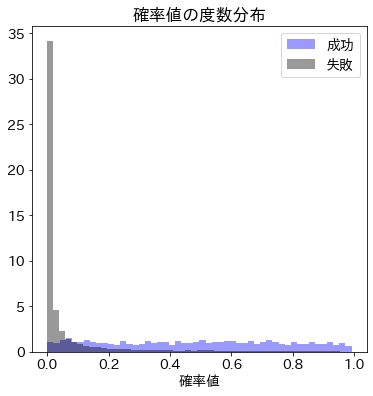

In [19]:
# 確率値の度数分布グラフ
import seaborn as sns

# y=1の確率値取得
y_proba1 = algorithm.predict_proba(x_test)[:, 1]

# y_test=0とy_test=1でデータ分割
y0 = y_proba1[y_test==0]
y1 = y_proba1[y_test==1]

# 散布図描画
plt.figure(figsize=(6, 6))
plt.title('確率値の度数分布')
sns.distplot(y1, kde=False, norm_hist=True, bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True, bins=50, color='k', label='失敗')
plt.xlabel('確率値')
plt.legend()
plt.show()

In [20]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得（行列）
    y_proba = algorithm.predict_proba(x)

    # 予測結果1の確率値
    y_proba1 = y_proba[:, 1]

    # 予測結果1の確率値 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [21]:
# 閾値を0.05刻みに変化させて、適合率、再現率、F値を計算する
thres_list = np.arange(0.5, 0, -0.05)
for thres in thres_list:
    y_pred = pred(algorithm, x_test, thres)
    pred_sum = y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    print(f'閾値: {thres:.2f} 陽性予測数: {pred_sum}\
    適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}')

閾値: 0.50 陽性予測数: 1612    適合率: 0.6290 再現率: 0.4792 F値: 0.5440
閾値: 0.45 陽性予測数: 1839    適合率: 0.6117 再現率: 0.5317 F値: 0.5689
閾値: 0.40 陽性予測数: 2041    適合率: 0.6022 再現率: 0.5808 F値: 0.5913
閾値: 0.35 陽性予測数: 2304    適合率: 0.5820 再現率: 0.6337 F値: 0.6068
閾値: 0.30 陽性予測数: 2544    適合率: 0.5688 再現率: 0.6838 F値: 0.6210
閾値: 0.25 陽性予測数: 2831    適合率: 0.5440 再現率: 0.7278 F値: 0.6226
閾値: 0.20 陽性予測数: 3184    適合率: 0.5135 再現率: 0.7727 F値: 0.6170
閾値: 0.15 陽性予測数: 3616    適合率: 0.4806 再現率: 0.8214 F値: 0.6064
閾値: 0.10 陽性予測数: 4277    適合率: 0.4361 再現率: 0.8814 F値: 0.5835
閾値: 0.05 陽性予測数: 5519    適合率: 0.3629 再現率: 0.9466 F値: 0.5247


In [22]:
# F値を最大にする閾値は0.30
y_final = pred(algorithm, x_test, 0.30)

# 混同行列を出力
df_matrix2 = make_cm(
    confusion_matrix(y_test, y_final), ['失敗', '成功']
)
display(df_matrix2)

# 適合率, 再現率, f1値を計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average='binary'
)
print(f'適合率: {precision:.4f}    再現率: {recall:.4f}\
    F値: {fscore:.4f}')

予測結果      
             失敗    成功
正解データ 失敗  14872  1097
      成功    669  1447

適合率: 0.5688    再現率: 0.6838    F値: 0.6210
